## Numpy tests

In [1]:
import numpy as np
print('OK')

OK


In [1]:
import datetime
datetime.datetime.now()

datetime.datetime(2022, 5, 13, 14, 48, 51, 289386)

## Charge parameters

In [5]:
import grid2op
import numpy as np
from lightsim2grid import LightSimBackend
from grid2op.Chronics import MultifolderWithCache
from l2rpn_baselines.utils import GymEnvWithRecoWithDN
from grid2op.Parameters import Parameters
from grid2op.utils import ScoreL2RPN2020
import torch
import datetime
import sys
import re
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import *

from examples.ppo_stable_baselines.B_train_agent import CustomReward

In [6]:
ENV_NAME = "l2rpn_wcci_2022_dev"

# Split sets and statistics parameters
is_windows = sys.platform.startswith("win32")
is_windows_or_darwin = sys.platform.startswith("win32") or sys.platform.startswith("darwin")
nb_process_stats = 4 if not is_windows_or_darwin else 1
deep_copy = is_windows  # force the deep copy on windows (due to permission issue in symlink in windows)
verbose = 1
SCOREUSED = ScoreL2RPN2020  # ScoreICAPS2021
name_stats = "_reco_powerline"

# Train parameters
env_name_train = '_'.join([ENV_NAME, "train"])
save_path = "./saved_model"
name = '_'.join(["GymEnvWithRecoWithDN", datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')])
gymenv_class = GymEnvWithRecoWithDN

In [8]:
# def filter_chronics(x):
#   list_chronics = ['2050-01-10_0', '2050-08-01_7'] # Names of chronics to keep
#   p = re.compile(".*(" + '|'.join([c + '$' for c in list_chronics]) + ")")
#   return re.match(p, x) is not None

def filter_chronics(x):
  list_chronics = ['2050-01-03_31', '2050-02-21_31', '2050-03-07_31', '2050-04-18_31'] # Names of chronics to keep
  p = re.compile(".*(" + '|'.join([c + '$' for c in list_chronics]) + ")")
  return re.match(p, x) is not None

In [9]:
with open("./preprocess_obs.json", "r", encoding="utf-8") as f:
    obs_space_kwargs = json.load(f)
with open("./preprocess_act.json", "r", encoding="utf-8") as f:
    act_space_kwargs = json.load(f)

In [27]:
p=Parameters()
p.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION = True

env_train = grid2op.make(ENV_NAME,
                   reward_class=CustomReward2,
                   backend=LightSimBackend(),
                   chronics_class=MultifolderWithCache,
                   param=p,
                   other_rewards={"CustomReward2": CustomReward2}
                   )
env_train.chronics_handler.real_data.set_filter(filter_chronics)
env_train.chronics_handler.real_data.reset()

nb_scenario = len(env_train.chronics_handler.real_data.available_chronics())

In [28]:
env_train.chronics_handler.real_data.available_chronics()

array(['/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-01-03_31',
       '/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-02-21_31',
       '/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-03-07_31',
       '/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-04-18_31'],
      dtype='<U76')

## Test Runner

In [14]:
from grid2op.Runner import Runner
from examples.ppo_stable_baselines.C_evaluate_trained_model import load_agent

from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(observation_space=env_train.observation_space)

In [15]:
agent_name = "GymEnvWithRecoWithDN_2022-05-12_21-37_learning_rate_3"
path_agent = os.path.join(save_path, agent_name)
path_results_agent = os.path.join("./model_results", agent_name)

In [45]:
my_agent = load_agent(env_train, 
    load_path=save_path, 
    name=agent_name, 
    gymenv_class=gymenv_class, 
    gymenv_kwargs={"safe_max_rho": 0.2},
    obs_space_kwargs=obs_space_kwargs,
    act_space_kwargs=act_space_kwargs)

In [46]:
runner_params = env_train.get_params_for_runner()
runner_params["verbose"] = verbose
runner = Runner(**runner_params, agentClass=None, agentInstance=my_agent)

In [47]:
os.makedirs(path_results_agent, exist_ok=True)

res = runner.run(path_save=path_results_agent, 
    nb_episode=nb_scenario, 
    nb_process=1, 
    max_iter=-1, 
    pbar=True,
    env_seeds=get_env_seed(ENV_NAME)[:nb_scenario], 
    # env_seeds=[42 for _ in range(nb_scenario)],
    agent_seeds=[0 for _ in range(nb_scenario)])

episode:  12%|█▏        | 240/2017 [00:00<00:06, 275.20it/s]


2050-01-03_31: env.nb_time_step = 240, reward : 0.345
2050-01-03_31: env.nb_time_step = 240, reward : 0.345


episode:  11%|█▏        | 230/2017 [00:00<00:06, 272.59it/s]


2050-02-21_31: env.nb_time_step = 230, reward : 0.338
2050-02-21_31: env.nb_time_step = 230, reward : 0.338


episode:   7%|▋         | 133/2017 [00:00<00:06, 275.52it/s]


2050-03-07_31: env.nb_time_step = 133, reward : 0.257
2050-03-07_31: env.nb_time_step = 133, reward : 0.257


episode:   5%|▌         | 105/2017 [00:00<00:06, 276.44it/s]


2050-04-18_31: env.nb_time_step = 105, reward : 0.228
2050-04-18_31: env.nb_time_step = 105, reward : 0.228


episode: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


## Barplot and boxplot

In [64]:
agents_names = [el for el in os.listdir(save_path) if re.match(r'GymEnv.*', el) is not None]

total_results = np.zeros((len(agents_names), nb_scenario, 3))
for i, agent_name in enumerate(agents_names):
  results = eval_agent(ENV_NAME, #env_name_val,
            nb_scenario,
            agent_name,
            save_path,
            SCOREUSED,
            gymenv_class,
            verbose,
            gymenv_kwargs={"safe_max_rho":0.2},
            param=p,
            filter_fun=filter_chronics)
  for k in range(3):
    total_results[i, :, k]=np.array(results[k])
  # print(results)

Starts the evaluation of the agent
Start the evaluation of the scores
	:-( I survived 123 steps vs 239 for do nothing (-116)
	:-) I survived 3 steps vs 3 for do nothing (0)
	:-) I survived 117 steps vs 115 for do nothing (2)
	:-( I survived 124 steps vs 142 for do nothing (-18)
The agent "GymEnvWithRecoWithDN_2022-05-12_19-55_learning_rate_3" beats "do nothing" baseline in 2 out of 4 episodes
	:-( I survived 123 steps vs 239 for reco powerline (-116)
	:-) I survived 3 steps vs 3 for reco powerline (0)
	:-) I survived 117 steps vs 115 for reco powerline (2)
	:-( I survived 124 steps vs 142 for reco powerline (-18)
The agent "GymEnvWithRecoWithDN_2022-05-12_19-55_learning_rate_3" beats "reco powerline" baseline in 2 out of 4 episodes
Starts the evaluation of the agent
Start the evaluation of the scores
	:-( I survived 238 steps vs 239 for do nothing (-1)
	:-) I survived 230 steps vs 3 for do nothing (227)
	:-) I survived 165 steps vs 115 for do nothing (50)
	:-) I survived 1564 steps vs 

In [69]:
# Agregation des initialisations pour affichage
nb_init = 4
total_results_mean = np.zeros((len(agents_names)//nb_init, nb_scenario, 3))
total_results_std = np.zeros((len(agents_names)//nb_init, nb_scenario, 3))
dict_ts_survived = {}
for i_val in range(total_results_mean.shape[0]):
    pattern = re.compile('.*' + str(i_val) + '$')
    index = np.where([re.match(pattern, el) is not None for el in agents_names])[0]
    dict_ts_survived.update({f"Agent_{i_val}" : total_results[index, :, 0].T})
    total_results_mean[i_val] = np.mean(total_results[index], axis=0)
    total_results_std[i_val] = np.std(total_results[index], axis=0)

In [67]:
def create_bar_plot(dict_ts_survived, dn_ts_survived, reco_ts_survived, path=None):
  scenarios = [i+1 for i in range(len(dn_ts_survived))] + ["Mean"]
  d = {"Scenarios": scenarios,
       "Do Nothing": np.append(dn_ts_survived, dn_ts_survived.mean()),
       "Reco": np.append(reco_ts_survived, reco_ts_survived.mean())}

  for key, value in dict_ts_survived.items():
    dict_ts_survived[key] = np.append(value, value.mean())

  d.update(dict_ts_survived)
       
  df = pd.DataFrame(d)
  tidy = df.melt(id_vars="Scenarios").rename(columns=str.title)
  tidy.rename(columns={"Value": "Survived steps", "Variable": "Agents"}, inplace=True)
  fig, ax1 = plt.subplots(figsize=(10, 5))
  sns.barplot(x="Scenarios", y="Survived steps", hue="Agents", data=tidy, palette=("magma"), ax=ax1)
  ax1.axhline(2017, color="black", label="Maximum time steps")
  plt.legend()
  sns.despine(fig)
  if path is not None:
    plt.savefig(path)
  plt.show()

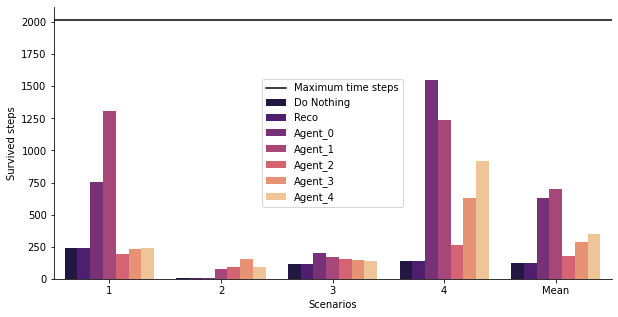

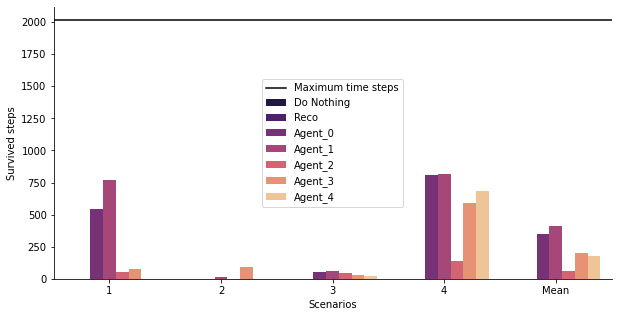

In [74]:
create_bar_plot({"Agent_0":total_results_mean[0, :, 0], 
                    "Agent_1":total_results_mean[1, :, 0],
                    "Agent_2":total_results_mean[2, :, 0],
                    "Agent_3":total_results_mean[3, :, 0],
                    "Agent_4":total_results_mean[4, :, 0]
                    },
                    total_results_mean[0, :, 1], 
                    total_results_mean[0, :, 2])

create_bar_plot({"Agent_0":total_results_std[0, :, 0], 
                    "Agent_1":total_results_std[1, :, 0],
                    "Agent_2":total_results_std[2, :, 0],
                    "Agent_3":total_results_std[3, :, 0],
                    "Agent_4":total_results_std[4, :, 0]
                    },
                    total_results_std[0, :, 1], 
                    total_results_std[0, :, 2])

In [22]:
import seaborn as sns

def create_box_plot(dict_ts_survived, dn_ts_survived, reco_ts_survived, path=None):
  d = {"Scenarios": [],
       "Agents": [],
       "Survived steps": []}

  for i, v in enumerate(dn_ts_survived):
    d["Scenarios"].append(i)
    d["Agents"].append("DN")
    d["Survived steps"].append(v)
  
  for i, v in enumerate(reco_ts_survived):
    d["Scenarios"].append(i)
    d["Agents"].append("Reco")
    d["Survived steps"].append(v)

  for key, scenarios in dict_ts_survived.items():
    for i, values in enumerate(scenarios):
      for v in values:
        d["Scenarios"].append(i)
        d["Agents"].append(key)
        d["Survived steps"].append(v)

  df = pd.DataFrame(d)

  fig, ax1 = plt.subplots(figsize=(10, 5))
  sns.boxplot(x="Scenarios", y="Survived steps", hue="Agents", data=df, palette=("magma"), ax=ax1)
  ax1.axhline(2017, color="black", label="Maximum time steps")
  plt.legend()
  sns.despine(fig)
  if path is not None:
    plt.savefig(path)
  plt.show()

In [72]:
total_results.shape

(20, 4, 3)

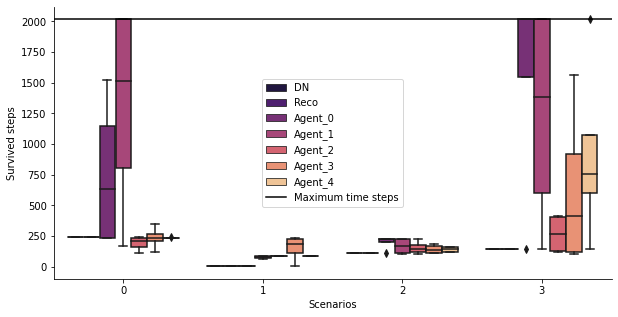

In [73]:
create_box_plot(dict_ts_survived, total_results_mean[0, :, 1], total_results_mean[0, :, 2])

## Test different seeds on fixed scenario

In [16]:
from grid2op.Agent import RecoPowerlineAgent, DoNothingAgent

In [46]:
agents_list = [(load_agent(env_train, 
                            load_path=save_path, 
                            name=agent_name, 
                            gymenv_class=gymenv_class, 
                            gymenv_kwargs={"safe_max_rho": 0.2},
                            obs_space_kwargs=obs_space_kwargs,
                            act_space_kwargs=act_space_kwargs), agent_name) for agent_name in 
                            ["GymEnvWithRecoWithDN_2022-05-13_18-49_learning_rate_0",
                            "GymEnvWithRecoWithDN_2022-05-13_18-51_learning_rate_0"]]
agents_list.append((DoNothingAgent(env_train.action_space), "DoNothingAgent"))
agents_list.append((RecoPowerlineAgent(env_train.action_space), "RecoPowerlineAgent"))

max_int = np.iinfo(dt_int).max
env_seeds_list=[np.random.randint(low=0,
                            high=max_int,
                            size=nb_scenario,
                            dtype=dt_int) for _ in range(3)]

results_list = []
results_dict = {}
for agent, agent_name in agents_list:
    results_dict[agent_name]=[]
    for env_seeds in env_seeds_list:
        results = eval_agent(ENV_NAME, #env_name_val,
                    nb_scenario,
                    agent_name,
                    save_path,
                    SCOREUSED,
                    gymenv_class,
                    verbose,
                    gymenv_kwargs={"safe_max_rho":0.2},
                    param=p,
                    filter_fun=filter_chronics,
                    env_seeds=env_seeds,
                    my_agent=agent)
        results_dict[agent_name].append(results[0])
        results_list.append([env_seeds, agent_name, results[0]])
results_dict = {k: np.array(v).T for k,v in results_dict.items()}

You changed env_seeds for your agent, but not for dn_agent and reco_agent so you receive empty lists
Starts the evaluation of the agent
Start the evaluation of the scores
You changed env_seeds for your agent, but not for dn_agent and reco_agent so you receive empty lists
Starts the evaluation of the agent
Start the evaluation of the scores
You changed env_seeds for your agent, but not for dn_agent and reco_agent so you receive empty lists
Starts the evaluation of the agent
Start the evaluation of the scores
You changed env_seeds for your agent, but not for dn_agent and reco_agent so you receive empty lists
Starts the evaluation of the agent
Start the evaluation of the scores
You changed env_seeds for your agent, but not for dn_agent and reco_agent so you receive empty lists
Starts the evaluation of the agent
Start the evaluation of the scores
You changed env_seeds for your agent, but not for dn_agent and reco_agent so you receive empty lists
Starts the evaluation of the agent
Start the

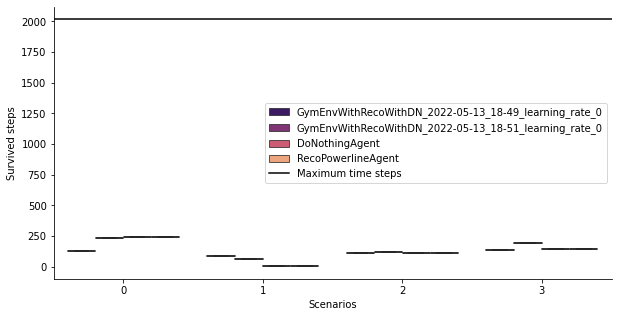

({'GymEnvWithRecoWithDN_2022-05-13_18-49_learning_rate_0': array([[130, 130, 130],
         [ 92,  92,  92],
         [111, 111, 111],
         [137, 137, 137]]),
  'GymEnvWithRecoWithDN_2022-05-13_18-51_learning_rate_0': array([[236, 236, 236],
         [ 65,  65,  65],
         [121, 121, 121],
         [193, 193, 193]]),
  'DoNothingAgent': array([[239, 239, 239],
         [  3,   3,   3],
         [115, 115, 115],
         [142, 142, 142]]),
  'RecoPowerlineAgent': array([[239, 239, 239],
         [  3,   3,   3],
         [115, 115, 115],
         [142, 142, 142]])},
 None)

In [48]:
results_dict, create_box_plot(results_dict, [], [])

In [53]:
env_train._opponent_budget_class

grid2op.Opponent.NeverAttackBudget.NeverAttackBudget

## Study episodes

In [19]:
from grid2op.Episode import EpisodeData
episode_studied = EpisodeData.list_episode(path_results_agent)
episode_studied

[('/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/model_results/GymEnvWithRecoWithDN_2022-05-06_12-38_gymenv_kwargs_0',
  '2050-01-10_0'),
 ('/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/model_results/GymEnvWithRecoWithDN_2022-05-06_12-38_gymenv_kwargs_0',
  '2050-08-01_7')]

In [20]:
this_episode = EpisodeData.from_disk(*episode_studied[1])

In [21]:
i = 0
for t, act in enumerate(this_episode.actions):
    if act != env_train.action_space(): # Print only when an action is done
        i += 1
        obs = this_episode.observations[t]
        print(i)
        print(t)
        print(act)
        # _ = plot_helper.plot_obs(obs)

1
0
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - Modify the storage units in the following way:
	 	 - Ask unit "storage_22_0" to produce 0.85 MW (setpoint: -0.85 MW)
	 	 - Ask unit "storage_41_1" to absorb 8.67 MW (setpoint: 8.67 MW)
	 	 - Ask unit "storage_44_2" to produce 0.19 MW (setpoint: -0.19 MW)
	 	 - Ask unit "storage_58_3" to absorb 3.83 MW (setpoint: 3.83 MW)
	 	 - Ask unit "storage_76_4" to produce 4.39 MW (setpoint: -4.39 MW)
	 	 - Ask unit "storage_95_5" to absorb 6.22 MW (setpoint: 6.22 MW)
	 	 - Ask unit "storage_112_6" to absorb 0.47 MW (setpoint: 0.47 MW)
	 - Perform the following curtailment:
	 	 - Limit unit "gen_3_0" to 100.0% of its Pmax (setpoint: 1.000)
	 	 - Limit unit "gen_3_1" to 100.0% of its Pmax (setpoint: 1.000)
	 	 - Limit unit "gen_9_3" to 0.0% of its Pmax (setpoint: 0.000)
	 	 - Limit unit "gen_10_4" to 100.0% of its Pmax (setpoint: 1.000)
	 	 - Limit unit "gen_10_5" to 0.0% of its Pmax (setpoi

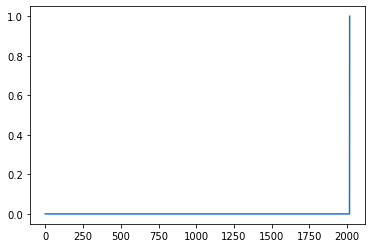

In [16]:
plt.plot(this_episode.rewards)

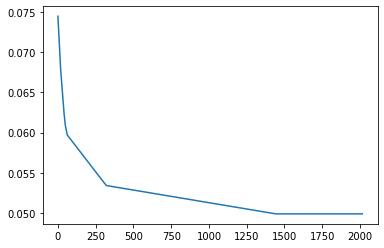

In [17]:
plt.plot([el['CustomReward2'] for el in this_episode.other_rewards][:-1])

In [129]:
this_episode.actions[0].curtail, this_episode.actions[0].set_storage

(array([ 1.        ,  1.        , -1.        ,  0.        ,  1.        ,
         0.55113685, -1.        ,  0.        , -1.        ,  1.        ,
        -1.        ,  1.        ,  1.        , -1.        ,  1.        ,
         1.        ,  1.        ,  0.        ,  0.        , -1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -1.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         1.        , -1.        , -1.        ,  0.        ,  1.        ,
        -1.        ,  1.        , -1.        , -1.        ,  1.        ,
         0.        , -1.        , -1.        ,  1.        ,  0.        ,
        -1.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        , -1.        ,  1.        , -1.        ,  0.9917599 ,
        -1.        ,  1.        ,  1.        , -1.        ,  1.        ,
        -1.        ,  0.        ], dtype=float32),
 array([-8.645507  ,  1.4393748 ,  6.17998   ,  4.3085036 ,  7.1264153 ,


**Regarder les observations et non les actions**

## Training curves

In [43]:
from l2rpn_baselines.PPO_SB3 import evaluate

In [49]:
trained_agent, details = evaluate(env_train,
                                nb_episode=nb_scenario,
                                load_path=save_path,
                                name=agent_name,
                                gymenv_class=gymenv_class,
                                iter_num=700000,
                                # iter_num=630000,
                                gymenv_kwargs={"safe_max_rho":0.2},
                                obs_space_kwargs=obs_space_kwargs,
                                act_space_kwargs=act_space_kwargs
                                )
details

2050-01-03_31: env.nb_time_step = 240, reward : 0.345
2050-01-03_31: env.nb_time_step = 240, reward : 0.345
2050-02-21_31: env.nb_time_step = 145, reward : 0.268
2050-02-21_31: env.nb_time_step = 145, reward : 0.268
2050-03-07_31: env.nb_time_step = 165, reward : 0.286
2050-03-07_31: env.nb_time_step = 165, reward : 0.286
2050-04-18_31: env.nb_time_step = 108, reward : 0.231
2050-04-18_31: env.nb_time_step = 108, reward : 0.231


[('/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-01-03_31',
  '2050-01-03_31',
  20.722827747378613,
  240,
  2017),
 ('/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-02-21_31',
  '2050-02-21_31',
  12.925922999755656,
  145,
  2017),
 ('/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-03-07_31',
  '2050-03-07_31',
  13.859306803496423,
  165,
  2017),
 ('/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-04-18_31',
  '2050-04-18_31',
  9.628379209975522,
  108,
  2017)]

In [62]:
nb_iterations = 700_000
nb_iterations_list = np.arange(stop=nb_iterations+1, step=nb_iterations//10)[1:]
# agents_names_list = ["GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_0", 
#                       "GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_1", 
#                       "GymEnvWithRecoWithDN_2022-04-23_01-20_learning_rate_2"]

agents_names_list = [
    "GymEnvWithRecoWithDN_2022-05-12_19-55_learning_rate_1",
    "GymEnvWithRecoWithDN_2022-05-12_21-35_learning_rate_1",
    "GymEnvWithRecoWithDN_2022-05-12_21-37_learning_rate_1",
    "GymEnvWithRecoWithDN_2022-05-12_21-37_learning_rate_1",
    "GymEnvWithRecoWithDN_2022-05-12_19-55_learning_rate_3",
    "GymEnvWithRecoWithDN_2022-05-12_21-35_learning_rate_3",
    "GymEnvWithRecoWithDN_2022-05-12_21-37_learning_rate_3",
    "GymEnvWithRecoWithDN_2022-05-12_21-37_learning_rate_3"]
                        



global_res = np.zeros((nb_scenario, len(agents_names_list), 2, nb_iterations_list.shape[0]))

for i, agent_name in enumerate(agents_names_list):
    for j, nb_iter in enumerate(nb_iterations_list):
        _, details = evaluate(env_train, #env_train,
                                nb_episode=nb_scenario,
                                load_path=save_path,
                                name=agent_name,
                                gymenv_class=gymenv_class,
                                iter_num=nb_iter,
                                gymenv_kwargs={"safe_max_rho":0.2},
                                obs_space_kwargs=obs_space_kwargs,
                                act_space_kwargs=act_space_kwargs)

        # print(details)
        for l, el in enumerate(details):
            # print(global_res[l, i, j])
            # print(el[3])
            global_res[l, i, 0, j] = el[2] # Reward
            global_res[l, i, 1, j] = el[3]  # Timesteps survived

        print(agent_name, nb_iter)
        # print(global_res)
    
    

2050-01-03_31: env.nb_time_step = 440, reward : 0.467
2050-01-03_31: env.nb_time_step = 440, reward : 0.467
2050-02-21_31: env.nb_time_step = 89, reward : 0.210
2050-02-21_31: env.nb_time_step = 89, reward : 0.210
2050-03-07_31: env.nb_time_step = 219, reward : 0.330
2050-03-07_31: env.nb_time_step = 219, reward : 0.330
2050-04-18_31: env.nb_time_step = 2017, reward : 1.000
2050-04-18_31: env.nb_time_step = 2017, reward : 1.000
GymEnvWithRecoWithDN_2022-05-12_19-55_learning_rate_1 70000
2050-01-03_31: env.nb_time_step = 443, reward : 0.469
2050-01-03_31: env.nb_time_step = 443, reward : 0.469
2050-02-21_31: env.nb_time_step = 91, reward : 0.212
2050-02-21_31: env.nb_time_step = 91, reward : 0.212
2050-03-07_31: env.nb_time_step = 118, reward : 0.242
2050-03-07_31: env.nb_time_step = 118, reward : 0.242
2050-04-18_31: env.nb_time_step = 119, reward : 0.243
2050-04-18_31: env.nb_time_step = 119, reward : 0.243
GymEnvWithRecoWithDN_2022-05-12_19-55_learning_rate_1 140000
2050-01-03_31: en

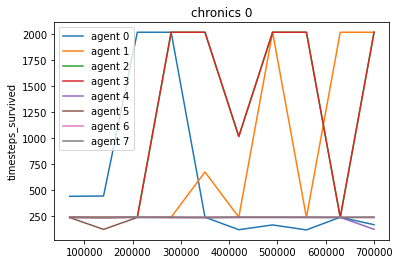

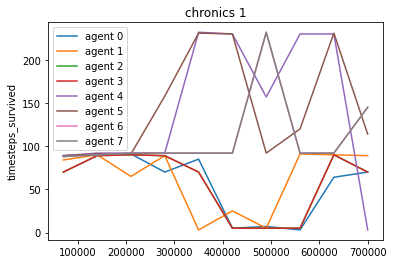

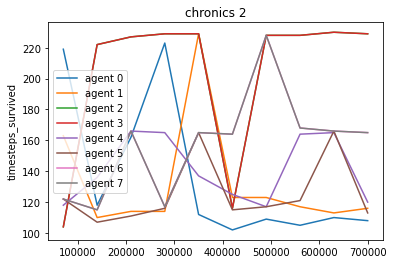

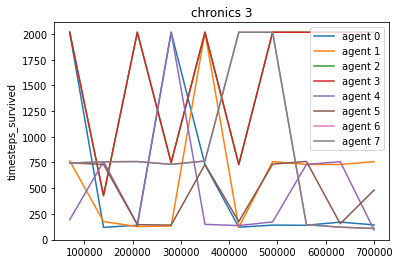

In [63]:
for chronics_num in range(nb_scenario):
    for k, y_name in enumerate(["timesteps_survived"]):
        plt.title("chronics " + str(chronics_num))
        plt.ylabel(y_name)
        for agent_num in range(len(agents_names_list)):
            plt.plot(nb_iterations_list, global_res[chronics_num, agent_num, 1], label="agent "+str(agent_num))
        plt.legend()
        plt.show()


## Learning rate function

In [121]:
def lr_fun(x_left):
    x = 1 - x_left
    lr = 0
    if x <= 0.25:
        lr = 1e-3 + (1e-5 - 1e-3) * x / 0.25
    else :
        lr = 1e-5
    return lr
    


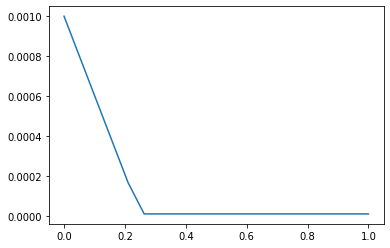

In [125]:
plt.plot(np.linspace(0,1,20), [lr_fun(1-el) for el in np.linspace(0,1,20)])


## Test CustomReward

In [71]:
env_train2 = grid2op.make(ENV_NAME, 
                            reward_class=CustomReward2, 
                            param=p, 
                            backend=LightSimBackend(),
                            chronics_class=MultifolderWithCache)
env_train2.chronics_handler.real_data.set_filter(filter_chronics)
env_train2.chronics_handler.real_data.reset()

array(['/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-01-10_0',
       '/home/boguslawskieva/data_grid2op/l2rpn_wcci_2022_dev/chronics/2050-08-01_7'],
      dtype='<U75')

In [5]:
env = grid2op.make(ENV_NAME, reward_class=CustomReward)

In [6]:
def sample_curtailment(env, rnd_update=None):
        unitary_actions = env.action_space.get_all_unitary_curtail(env.action_space)
        rnd_update = env.space_prng.choice(unitary_actions)
        return rnd_update

def sample_storage(env, rnd_update=None):
        unitary_actions = env.action_space.get_all_unitary_storage(env.action_space)
        rnd_update = env.space_prng.choice(unitary_actions)
        return rnd_update


act = env.space_prng.choice([sample_curtailment(env), sample_storage(env)])
act.as_serializable_dict()

{'curtail': [(7, 0.7222222089767456)]}

In [10]:
act = env.space_prng.choice([sample_curtailment(env), sample_storage(env)])
print(act.as_serializable_dict())
obs, reward, done, info = env.step(act)
reward, done

{'set_storage': [(0, -6.0)]}


(0.0, False)

In [13]:
obs.curtailment_mw, obs.curtailment_limit, obs.curtailment_limit_effective#, obs.storage_charge/obs.storage_Emax

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 0.6666667, 0.8333333,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
        1.       , 1.       , 1.     

In [45]:
obs.storage_charge, obs.storage_Emin, obs.storage_Emax

(array([24., 12., 24., 12., 24., 24., 12.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([48., 24., 48., 24., 48., 48., 24.], dtype=float32))

# Test normalization

In [8]:
from grid2op.gym_compat import BoxGymActSpace, BoxGymObsSpace, GymEnv

from l2rpn_baselines.PPO_SB3.utils import (default_obs_attr_to_keep, 
                                           default_act_attr_to_keep,
                                           remove_non_usable_attr,
                                           save_used_attribute)

obs_attr_to_keep = ["month", "day_of_week", "hour_of_day", "minute_of_hour",
                                  "gen_p", "load_p", 
                                  "p_or", "rho", "timestep_overflow", "line_status",
                                  # dispatch part of the observation
                                  "actual_dispatch", "target_dispatch",
                                  # storage part of the observation
                                  "storage_charge", "storage_power",
                                  # curtailment part of the observation
                                  "curtailment", "curtailment_limit",  "gen_p_before_curtail",
                                  ]
act_attr_to_keep = ["curtail", "set_storage"]

act_attr_to_keep = remove_non_usable_attr(env_train, act_attr_to_keep)


# define the gym environment from the grid2op env
gymenv_kwargs = {"safe_max_rho":0.9}
env_gym = gymenv_class(env_train, **gymenv_kwargs)
env_gym.observation_space.close()
env_gym.observation_space = BoxGymObsSpace(env_train.observation_space,
                                        attr_to_keep=obs_attr_to_keep)
env_gym.action_space.close()
env_gym.action_space = BoxGymActSpace(env_train.action_space,
                                    attr_to_keep=act_attr_to_keep)

In [35]:
# {el:env_gym.action_space.dict_properties[el] for el in act_attr_to_keep}
# {el:env_gym.observation_space.dict_properties[el] for el in obs_attr_to_keep}
env_gym.action_space.low, env_gym.action_space.high
env_gym.observation_space.low, env_gym.observation_space.high

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))

In [24]:
# {el:env_gym.action_space.dict_properties[el] for el in act_attr_to_keep}
# {el:env_gym.observation_space.dict_properties[el] for el in obs_attr_to_keep}
{el:np.all(np.isfinite(env_gym.observation_space.dict_properties[el][0])) and np.all(np.isfinite(env_gym.observation_space.dict_properties[el][1])) 
    for el in obs_attr_to_keep}

{'month': True,
 'day_of_week': True,
 'hour_of_day': True,
 'minute_of_hour': True,
 'gen_p': True,
 'load_p': False,
 'p_or': False,
 'rho': False,
 'timestep_overflow': True,
 'line_status': True,
 'actual_dispatch': True,
 'target_dispatch': True,
 'storage_charge': True,
 'storage_power': True,
 'curtailment': True,
 'curtailment_limit': True,
 'gen_p_before_curtail': True}

In [23]:
normalize_act = True
normalize_obs = True
if normalize_act:
    for attr_nm in act_attr_to_keep:
        env_gym.action_space.normalize_attr(attr_nm)

if normalize_obs:
    for attr_nm in obs_attr_to_keep:
        env_gym.observation_space.normalize_attr(attr_nm)